# Applied MARVEL on complex MRF signals to obtain multiple quantitative maps

## Load the packages

In [ ]:
from time import time
import sys
import os
import json
import numpy as np

sys.path.append(os.path.join(os.getcwd(), os.pardir))

from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights
from Tools.reconstruction_utils import NN_prediction_complex
from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks import initialize_network

2025-06-17 00:23:23.347097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 00:23:23.367464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 00:23:23.373744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 00:23:23.390079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 00:23:24.286761: W tensorflow/compiler/tf2

## Load acquisition and ROI

In [ ]:
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

In [15]:
SENSE_reco_filepath= os.path.join(path_to_summer_current,"2023_MRF_Collab/Lila/tests_cg_sense/reco_acquisitions/reco_cg_sense/fixed_spirals/reco_cg_sense_alpha1_13shots.npy")
RECO_SENSE = np.load(SENSE_reco_filepath)

In [ ]:
roi_filepath = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424/ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219"

ROI_brain_map_filepath = os.path.join(path_to_summer_current, roi_filepath)

ROI_brain_map = load_acquisition_reconstruction_from_nii(ROI_brain_map_filepath, nb_indents=1, v=False)[0].astype(np.bool_)
ROI_brain_map = np.rot90(ROI_brain_map)

if ROI_brain_map.ndim == 2:
    ROI_brain_map = ROI_brain_map[:, :, None]

## Predict parameter maps

### Load the JSON file that contains the network parameters used for training. An example configuration file is provided in the MARVEL section. The main difference is the name of the network used.

In [ ]:
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/COMPLEX/training_from_magn_noise_phase')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [ ]:
#PARAMETERS TO SET
n_epochs = 87
n_pulses = 260

#PARAMETERS SET FROM RECOS_INFOS
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)
network_name = NETWORK_INFOS["network_name"]
input_size = n_pulses 
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))

2025-06-17 00:23:50.951726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41306 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5


### Preprocess the input data: 
###  - Reshape to (x, y, z, n_pulses)
###  - Normalize

In [ ]:
RECO = np.rot90(np.moveaxis(RECO_SENSE, 0, -1), 3)[:, :, None, :n_pulses]
RECO = np.nan_to_num(RECO, nan=0.0, posinf=0.0, neginf=0.0)

norm_RECO = np.linalg.norm(RECO, axis=3, keepdims=True)
norm_RECO_safe = np.maximum(norm_RECO, 1e-8)

RECO_normalized = RECO / norm_RECO_safe


### Predict and plot the quantitative maps

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


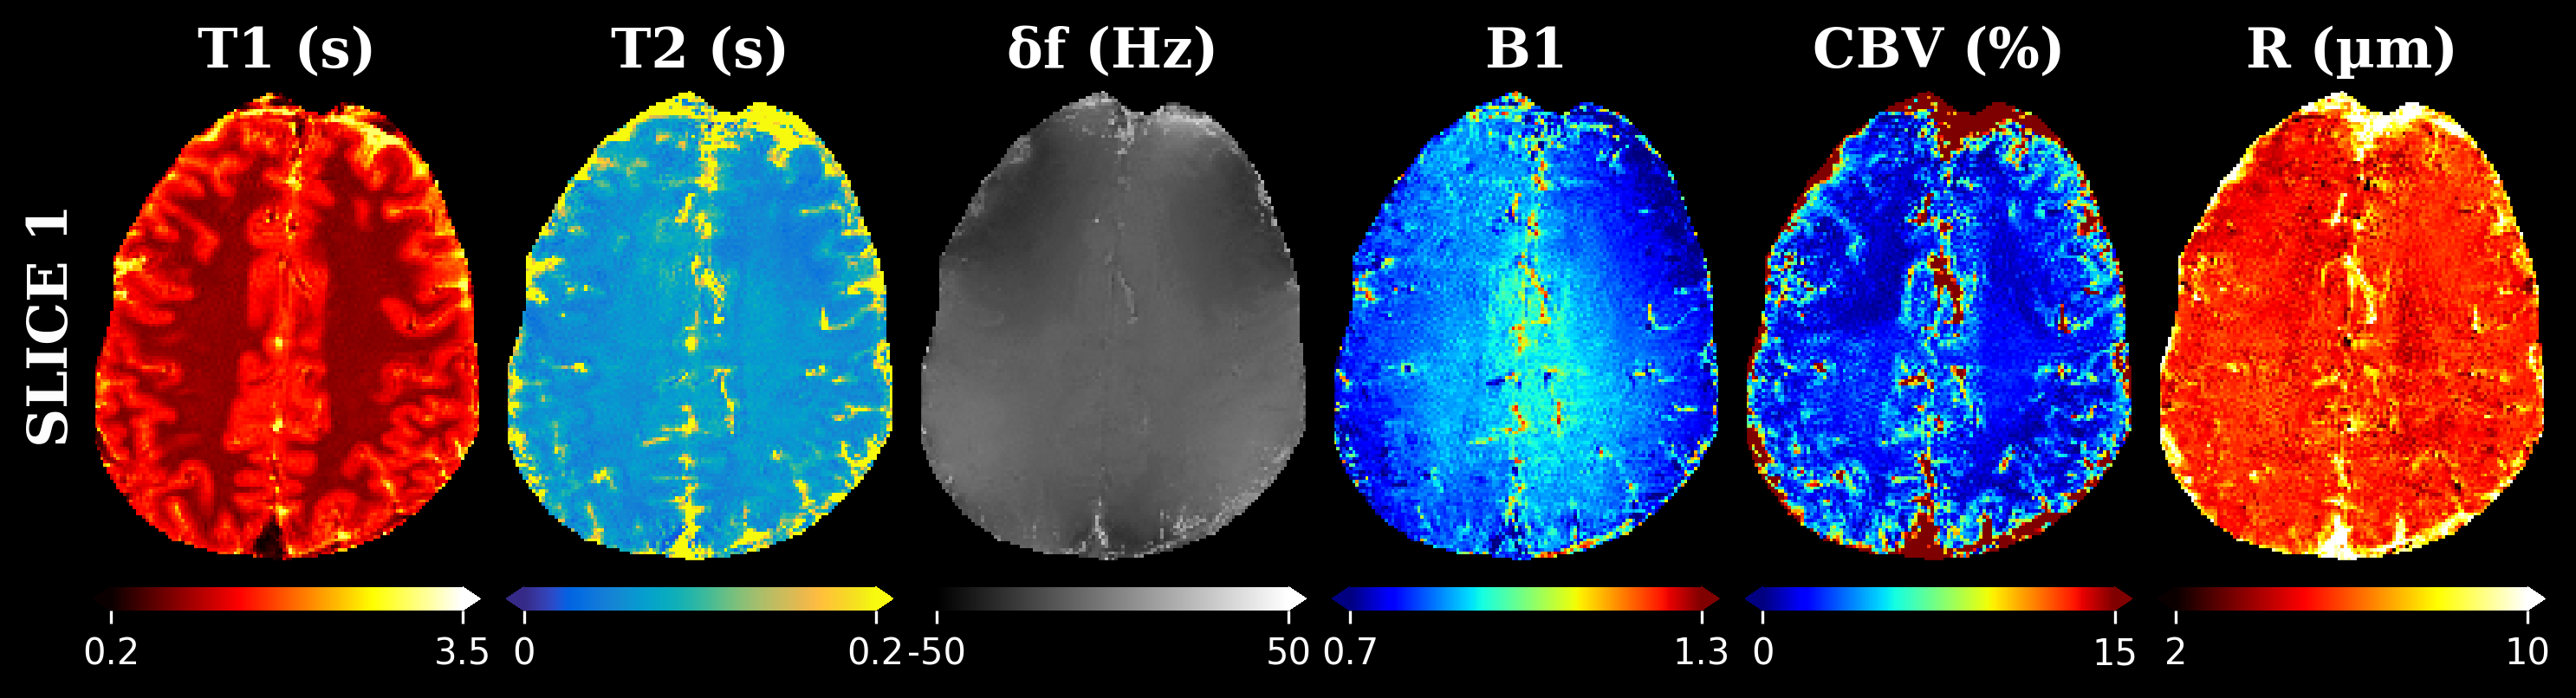

In [ ]:
reconstruction_us = NN_prediction_complex(NN, RECO_normalized, learned_labels, ROI_brain_map, batch_size=1024)

fig = plot_parameter_maps(reconstruction_us, learned_labels, crop_type='separate', title='')